<a href="https://colab.research.google.com/github/senanursahin/signal-classification-term-project/blob/main/Automatic_Signal_Modulation_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kullanılacak kütüphanelerin import edilmesi ve konfigürasyon ayarlarının tanımlanması

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np

# from keras.optimizers import adam
# from tensorflow.python.keras.optimizers import *

import keras
import tensorflow as tf

from keras.layers import *  # BatchNormalization, Conv2D, ZeroPadding2D, Dense,Dropout, Flatten,Reshape,
from keras.models import Sequential

# cpu yerine gpu kullandığım takdirde:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# from tensorflow.compat.v2.keras.utils import multi_gpu_model
# from keras.utils import multi_gpu_model

import _pickle as cPickle

# PKL dosyasından RML veri setinin okunması

In [ ]:
with open("RML2016.10a_dict.pkl", 'rb') as pkl_dosyası:  # Dataset = RML 2016.10a
    Xd = cPickle.load(pkl_dosyası, encoding="latin1")

Xd : sözlük tipindeki pkl verisi 

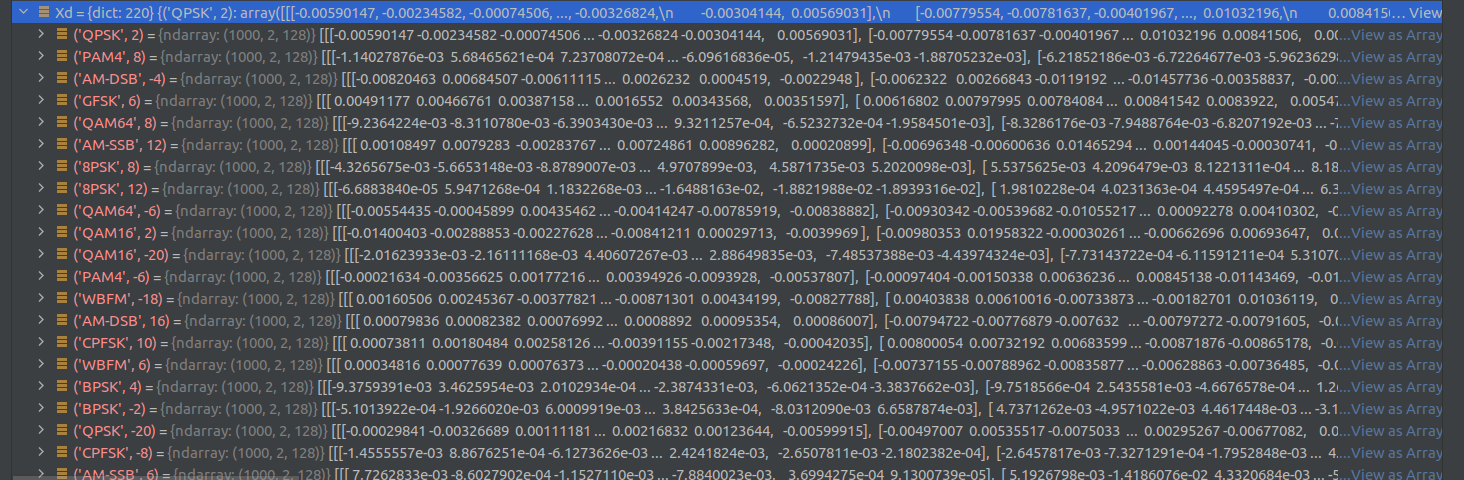

# PKL formatında çekilen verinin bizim kullanacağımız şekilde standart liste ve numpy matrixleri haline getirilmesi

In [ ]:
# mod = modülasyon şeması
# snr = signal to noise ratio (sinyal-gürültü oranı)

snr_listesi, mod_listesi = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = []
etiketler = []
for mod in mod_listesi:
    for snr in snr_listesi:
        X.append(Xd[(mod, snr)])
        
        for i in range(Xd[(mod, snr)].shape[0]):
            etiketler.append((mod, snr))

X = np.vstack(X)

mod_listesi:


```
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
```


snr_listesi:


```
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
```

etiketler:


```
[('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20...
```





### X olarak tuttuğumuz radyo sinyalleri matriksi:



```
[[[-0.00716379 -0.00241632  0.00063237 ... -0.00422343  0.00362227
    0.00533994]
  [-0.00166505 -0.00144848 -0.01196972 ...  0.00389698 -0.0052103
   -0.0007378 ]]

 [[ 0.00645143 -0.00212428 -0.00706135 ... -0.00565343 -0.00104959
   -0.00529411]
  [ 0.00329197 -0.00067204 -0.00282152 ...  0.00315403 -0.00091081
   -0.00107325]]

 [[ 0.00505826  0.00445021 -0.00706326 ... -0.00086023 -0.00832456
   -0.00439183]
  [ 0.00454194  0.00554406 -0.00336223 ...  0.01007818  0.00437446
    0.00157776]]

 ...

 [[ 0.00090855  0.00091193  0.00096988 ...  0.00087493  0.00092356
    0.00105166]
  [-0.00778397 -0.00787711 -0.00781963 ... -0.00772037 -0.00776644
   -0.00776909]]

 [[ 0.0009345   0.00097915  0.00097718 ...  0.000949    0.0010655
    0.00105054]
  [-0.00771043 -0.00773856 -0.00780745 ... -0.00780556 -0.00772785
   -0.00776188]]

 [[ 0.00091991  0.00093362  0.00092781 ...  0.0009634   0.00095325
    0.00106686]
  [-0.00772773 -0.00768794 -0.00775292 ... -0.00776374 -0.00768772
   -0.00772689]]]

```



# Elimizdeki verinin test ve eğitim için ayırılması

In [ ]:
örnek_sayısı = X.shape[0]  # 220000

# Eğitim veri setinde %80 örnek, testte %20
eğitim_sayısı = int(örnek_sayısı * 0.8)  # 176000
eğitim_idx = np.random.choice(range(0, örnek_sayısı), size=eğitim_sayısı, replace=False) # ndarray (176000,): [109751, 143919, 157116, 42129, ...]
test_idx = list(set(range(0, örnek_sayısı)) - set(eğitim_idx)) # list 44000: [3, 9, 131087, 21, ...]
X_eğitim = X[eğitim_idx]
X_test = X[test_idx]

In [ ]:
def onehot_uygula(yy):
    veri = list(yy)
    yy_onehot = np.zeros([len(veri), max(veri) + 1])
    yy_onehot[np.arange(len(veri)), veri] = 1
    return yy_onehot

### Eğitim ve test verileri için örnek çıktılar için onehot uygulanır

In [ ]:
Y_eğitim = onehot_uygula(map(lambda x: mod_listesi.index(etiketler[x][0]), eğitim_idx))
Y_test = onehot_uygula(map(lambda x: mod_listesi.index(etiketler[x][0]), test_idx))

# Model için gerekli parametrelerin tanımlanması

In [ ]:
girdi_boyutu = list(X_eğitim.shape[1:])

print(X_eğitim.shape, girdi_boyutu)
# beklenen çıktı: 
#   X_eğitim.shape: (176000, 2, 128) 
#   girdi_boyutu: [2, 128]

sınıflar = mod_listesi

# bırakma oranı?
dropout_rate = 0.6  # dropout rate (%)

eğitim_epoch_sayısı = 100
eğitim_batch_boyutu = 1024

(176000, 2, 128) [2, 128]


# Modellerin tanımlanması

In [ ]:
def ConvNet_modeli_olustur(batch_normalizasyonu, aktivasyon_adı, girdi_boyutu, dropout, sınıf_listesi):
    model = Sequential()
    
    model.add(Reshape([1] + girdi_boyutu, input_shape=girdi_boyutu))

    model.add(
        Conv2D(512, 
               (1, 2), 
               padding='same', 
               input_shape=(1, 2, 128), 
               activation=aktivasyon_adı,
               kernel_initializer='glorot_uniform'
               )
        )

    if batch_normalizasyonu: 
      model.add(BatchNormalization())

    model.add(Dropout(dropout))

    model.add(
        Conv2D(512, 
               (1, 2), 
               padding='same', 
               input_shape=(1, 2, 512),
               activation=aktivasyon_adı, 
               kernel_initializer='glorot_uniform'
               )
        )

    if batch_normalizasyonu: 
      model.add(BatchNormalization())

    model.add(Flatten())

    model.add(
        Dense(256, 
              activation=aktivasyon_adı, 
              kernel_initializer='he_normal'
              )
        )

    model.add(Dropout(dropout))

    model.add(Dense(len(sınıflar), activation='softmax'))
    
    model.add(Reshape([len(sınıflar)]))

    return model

# Oluşturduğumuz verisetleri için olan parametreler girdi olarak verilerek modelin oluşturulması

In [ ]:
# Conventional CNN

sig_model = ConvNet_modeli_olustur(
                                    batch_normalizasyonu=False,
                                    aktivasyon_adı='relu',
                                    girdi_boyutu=girdi_boyutu,
                                    dropout=dropout_rate,
                                    sınıf_listesi=sınıflar
                                    )

sig_model.compile(
                  loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['acc']
                  )

sig_model.build()

sig_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 512)         131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 2, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 2, 512)         524800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

Model:



```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 2, 512)         131584    
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2, 512)         524800    
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2827      
_________________________________________________________________
reshape_1 (Reshape)          (None, 11)                0         
=================================================================
Total params: 921,611
Trainable params: 921,611
Non-trainable params: 0
```



# Modelin eğitilmesi

In [ ]:
filepath = 'convmodrecnets1_CNN2_0.6.wts.h5'

history = sig_model.fit(X_eğitim,
                        Y_eğitim,
                        batch_size=eğitim_batch_boyutu,
                        epochs=eğitim_epoch_sayısı,
                        verbose=2,
                        validation_data=(X_test, Y_test),
                        callbacks=[
                            # buradaki parametreler ağırlıkların ne zaman dosyaya kaydedileceğini belirler. 
                            # eğitim sırasında periyodik olarak belirlenir.
                            keras.callbacks.ModelCheckpoint(
                                filepath, 
                                monitor='val_acc', 
                                verbose=0, 
                                save_best_only=True, 
                                mode='auto'),
                            keras.callbacks.EarlyStopping(
                                monitor='val_acc', 
                                patience=50, 
                                verbose=0, 
                                mode='auto')
                        ])

# eğitim bittiğinde eğitim esnasında kaydettiğimiz en iyi ağırlıkları yeniden yüklüyoruz. 
# en iyi sonuç = test/doğrulama için en düşük loss (kayıp) değerleri
sig_model.load_weights(filepath)

Epoch 1/100
172/172 - 370s - loss: 2.1249 - acc: 0.1941 - val_loss: 1.8509 - val_acc: 0.2926
Epoch 2/100
172/172 - 326s - loss: 1.8120 - acc: 0.3115 - val_loss: 1.6877 - val_acc: 0.3524
Epoch 3/100
172/172 - 363s - loss: 1.6993 - acc: 0.3516 - val_loss: 1.6163 - val_acc: 0.3749
Epoch 4/100
172/172 - 355s - loss: 1.6476 - acc: 0.3673 - val_loss: 1.5811 - val_acc: 0.3897
Epoch 5/100


# Eğitilen modelin test verisi ile kontrol edilmesi

In [ ]:
skor = sig_model.evaluate(X_test, Y_test, verbose=0, batch_size=eğitim_batch_boyutu)

### Lokalde yukarıdaki kod çalıştığında her bir epoch ta alınan değerler:



```
Epoch 1/100
172/172 - 109s - loss: 2.1216 - acc: 0.1929 - val_loss: 1.8355 - val_acc: 0.3145
Epoch 2/100
172/172 - 89s - loss: 1.8094 - acc: 0.3134 - val_loss: 1.6921 - val_acc: 0.3554
Epoch 3/100
172/172 - 78s - loss: 1.6981 - acc: 0.3514 - val_loss: 1.6078 - val_acc: 0.3858
Epoch 4/100
172/172 - 78s - loss: 1.6441 - acc: 0.3684 - val_loss: 1.5738 - val_acc: 0.3951
Epoch 5/100
172/172 - 78s - loss: 1.6229 - acc: 0.3763 - val_loss: 1.5597 - val_acc: 0.3960
Epoch 6/100
172/172 - 78s - loss: 1.6026 - acc: 0.3829 - val_loss: 1.5466 - val_acc: 0.3965
Epoch 7/100
172/172 - 78s - loss: 1.5874 - acc: 0.3878 - val_loss: 1.5287 - val_acc: 0.4070
Epoch 8/100
172/172 - 79s - loss: 1.5688 - acc: 0.3925 - val_loss: 1.5036 - val_acc: 0.4118
Epoch 9/100
172/172 - 79s - loss: 1.5349 - acc: 0.4001 - val_loss: 1.4669 - val_acc: 0.4209
Epoch 10/100
172/172 - 79s - loss: 1.5116 - acc: 0.4058 - val_loss: 1.4513 - val_acc: 0.4282
Epoch 11/100
172/172 - 79s - loss: 1.4946 - acc: 0.4114 - val_loss: 1.4421 - val_acc: 0.4273
Epoch 12/100
172/172 - 79s - loss: 1.4848 - acc: 0.4150 - val_loss: 1.4375 - val_acc: 0.4301
Epoch 13/100
172/172 - 79s - loss: 1.4769 - acc: 0.4175 - val_loss: 1.4309 - val_acc: 0.4289
Epoch 14/100
172/172 - 79s - loss: 1.4709 - acc: 0.4195 - val_loss: 1.4265 - val_acc: 0.4316
Epoch 15/100
172/172 - 79s - loss: 1.4627 - acc: 0.4225 - val_loss: 1.4269 - val_acc: 0.4326
Epoch 16/100
172/172 - 79s - loss: 1.4564 - acc: 0.4251 - val_loss: 1.4210 - val_acc: 0.4350
Epoch 17/100
172/172 - 79s - loss: 1.4508 - acc: 0.4270 - val_loss: 1.4205 - val_acc: 0.4374
Epoch 18/100
172/172 - 79s - loss: 1.4475 - acc: 0.4285 - val_loss: 1.4163 - val_acc: 0.4375
Epoch 19/100
172/172 - 79s - loss: 1.4415 - acc: 0.4304 - val_loss: 1.4222 - val_acc: 0.4378
Epoch 20/100
172/172 - 79s - loss: 1.4374 - acc: 0.4333 - val_loss: 1.4138 - val_acc: 0.4388
Epoch 21/100
172/172 - 79s - loss: 1.4323 - acc: 0.4348 - val_loss: 1.4103 - val_acc: 0.4413
Epoch 22/100
172/172 - 79s - loss: 1.4279 - acc: 0.4352 - val_loss: 1.4101 - val_acc: 0.4476
Epoch 23/100
172/172 - 79s - loss: 1.4247 - acc: 0.4361 - val_loss: 1.4080 - val_acc: 0.4384
Epoch 24/100
172/172 - 79s - loss: 1.4206 - acc: 0.4380 - val_loss: 1.4092 - val_acc: 0.4527
Epoch 25/100
172/172 - 79s - loss: 1.4180 - acc: 0.4403 - val_loss: 1.4058 - val_acc: 0.4513
Epoch 26/100
172/172 - 79s - loss: 1.4120 - acc: 0.4398 - val_loss: 1.4043 - val_acc: 0.4546
Epoch 27/100
172/172 - 79s - loss: 1.4093 - acc: 0.4421 - val_loss: 1.4038 - val_acc: 0.4397
Epoch 28/100
172/172 - 79s - loss: 1.4034 - acc: 0.4441 - val_loss: 1.4015 - val_acc: 0.4485
Epoch 29/100
172/172 - 79s - loss: 1.4037 - acc: 0.4434 - val_loss: 1.4029 - val_acc: 0.4484
Epoch 30/100
172/172 - 79s - loss: 1.3989 - acc: 0.4452 - val_loss: 1.4020 - val_acc: 0.4460
Epoch 31/100
172/172 - 79s - loss: 1.3948 - acc: 0.4460 - val_loss: 1.4035 - val_acc: 0.4576
Epoch 32/100
172/172 - 79s - loss: 1.3905 - acc: 0.4475 - val_loss: 1.3971 - val_acc: 0.4544
Epoch 33/100
172/172 - 79s - loss: 1.3889 - acc: 0.4497 - val_loss: 1.4038 - val_acc: 0.4549
Epoch 34/100
172/172 - 79s - loss: 1.3887 - acc: 0.4471 - val_loss: 1.4004 - val_acc: 0.4527
Epoch 35/100
172/172 - 79s - loss: 1.3849 - acc: 0.4485 - val_loss: 1.4002 - val_acc: 0.4577
Epoch 36/100
172/172 - 79s - loss: 1.3801 - acc: 0.4526 - val_loss: 1.3964 - val_acc: 0.4516
Epoch 37/100
172/172 - 79s - loss: 1.3785 - acc: 0.4503 - val_loss: 1.4029 - val_acc: 0.4479
Epoch 38/100
172/172 - 79s - loss: 1.3756 - acc: 0.4520 - val_loss: 1.4038 - val_acc: 0.4533
Epoch 39/100
172/172 - 79s - loss: 1.3736 - acc: 0.4539 - val_loss: 1.3988 - val_acc: 0.4600
Epoch 40/100
172/172 - 79s - loss: 1.3698 - acc: 0.4543 - val_loss: 1.3976 - val_acc: 0.4547
Epoch 41/100
172/172 - 79s - loss: 1.3654 - acc: 0.4559 - val_loss: 1.4064 - val_acc: 0.4565
Epoch 42/100
172/172 - 79s - loss: 1.3637 - acc: 0.4559 - val_loss: 1.3992 - val_acc: 0.4648
Epoch 43/100
172/172 - 79s - loss: 1.3629 - acc: 0.4563 - val_loss: 1.4017 - val_acc: 0.4560
Epoch 44/100
172/172 - 79s - loss: 1.3579 - acc: 0.4577 - val_loss: 1.4060 - val_acc: 0.4585
Epoch 45/100
172/172 - 79s - loss: 1.3548 - acc: 0.4597 - val_loss: 1.3977 - val_acc: 0.4603
Epoch 46/100
172/172 - 79s - loss: 1.3541 - acc: 0.4603 - val_loss: 1.3956 - val_acc: 0.4630
Epoch 47/100
172/172 - 79s - loss: 1.3510 - acc: 0.4605 - val_loss: 1.3999 - val_acc: 0.4584
Epoch 48/100
172/172 - 79s - loss: 1.3496 - acc: 0.4610 - val_loss: 1.4048 - val_acc: 0.4572
Epoch 49/100
172/172 - 79s - loss: 1.3448 - acc: 0.4625 - val_loss: 1.4039 - val_acc: 0.4563
Epoch 50/100
172/172 - 79s - loss: 1.3432 - acc: 0.4632 - val_loss: 1.4108 - val_acc: 0.4540
Epoch 51/100
172/172 - 79s - loss: 1.3420 - acc: 0.4628 - val_loss: 1.4098 - val_acc: 0.4618
Epoch 52/100
172/172 - 79s - loss: 1.3392 - acc: 0.4640 - val_loss: 1.4059 - val_acc: 0.4667
Epoch 53/100
172/172 - 79s - loss: 1.3360 - acc: 0.4643 - val_loss: 1.4053 - val_acc: 0.4552
Epoch 54/100
172/172 - 79s - loss: 1.3355 - acc: 0.4658 - val_loss: 1.4047 - val_acc: 0.4562
Epoch 55/100
172/172 - 79s - loss: 1.3340 - acc: 0.4661 - val_loss: 1.4138 - val_acc: 0.4587
Epoch 56/100
172/172 - 79s - loss: 1.3324 - acc: 0.4664 - val_loss: 1.4108 - val_acc: 0.4541
Epoch 57/100
172/172 - 79s - loss: 1.3280 - acc: 0.4671 - val_loss: 1.4082 - val_acc: 0.4565
Epoch 58/100
172/172 - 79s - loss: 1.3276 - acc: 0.4670 - val_loss: 1.4012 - val_acc: 0.4633
Epoch 59/100
172/172 - 79s - loss: 1.3251 - acc: 0.4694 - val_loss: 1.4041 - val_acc: 0.4630
Epoch 60/100
172/172 - 79s - loss: 1.3208 - acc: 0.4690 - val_loss: 1.4063 - val_acc: 0.4640
Epoch 61/100
172/172 - 79s - loss: 1.3183 - acc: 0.4700 - val_loss: 1.4075 - val_acc: 0.4636
Epoch 62/100
172/172 - 79s - loss: 1.3191 - acc: 0.4694 - val_loss: 1.4175 - val_acc: 0.4604
Epoch 63/100
172/172 - 79s - loss: 1.3158 - acc: 0.4730 - val_loss: 1.4052 - val_acc: 0.4615
Epoch 64/100
172/172 - 79s - loss: 1.3118 - acc: 0.4744 - val_loss: 1.4195 - val_acc: 0.4551
Epoch 65/100
172/172 - 79s - loss: 1.3126 - acc: 0.4737 - val_loss: 1.4149 - val_acc: 0.4607
Epoch 66/100
172/172 - 79s - loss: 1.3070 - acc: 0.4757 - val_loss: 1.4124 - val_acc: 0.4653
Epoch 67/100
172/172 - 79s - loss: 1.3057 - acc: 0.4752 - val_loss: 1.4174 - val_acc: 0.4622
Epoch 68/100
172/172 - 79s - loss: 1.3017 - acc: 0.4758 - val_loss: 1.4148 - val_acc: 0.4628
Epoch 69/100
172/172 - 79s - loss: 1.2994 - acc: 0.4781 - val_loss: 1.4237 - val_acc: 0.4643
Epoch 70/100
172/172 - 79s - loss: 1.3001 - acc: 0.4771 - val_loss: 1.4120 - val_acc: 0.4645
Epoch 71/100
172/172 - 79s - loss: 1.2985 - acc: 0.4786 - val_loss: 1.4281 - val_acc: 0.4622
Epoch 72/100
172/172 - 79s - loss: 1.2938 - acc: 0.4807 - val_loss: 1.4226 - val_acc: 0.4641
Epoch 73/100
172/172 - 79s - loss: 1.2921 - acc: 0.4816 - val_loss: 1.4263 - val_acc: 0.4622
Epoch 74/100
172/172 - 79s - loss: 1.2914 - acc: 0.4808 - val_loss: 1.4349 - val_acc: 0.4585
Epoch 75/100
172/172 - 79s - loss: 1.2893 - acc: 0.4822 - val_loss: 1.4280 - val_acc: 0.4626
Epoch 76/100
172/172 - 79s - loss: 1.2868 - acc: 0.4820 - val_loss: 1.4419 - val_acc: 0.4624
Epoch 77/100
172/172 - 79s - loss: 1.2849 - acc: 0.4852 - val_loss: 1.4230 - val_acc: 0.4594
Epoch 78/100
172/172 - 79s - loss: 1.2823 - acc: 0.4846 - val_loss: 1.4383 - val_acc: 0.4574
Epoch 79/100
172/172 - 79s - loss: 1.2791 - acc: 0.4873 - val_loss: 1.4384 - val_acc: 0.4593
Epoch 80/100
172/172 - 79s - loss: 1.2779 - acc: 0.4871 - val_loss: 1.4282 - val_acc: 0.4660
Epoch 81/100
172/172 - 79s - loss: 1.2769 - acc: 0.4871 - val_loss: 1.4317 - val_acc: 0.4601
Epoch 82/100
172/172 - 79s - loss: 1.2733 - acc: 0.4884 - val_loss: 1.4252 - val_acc: 0.4624
Epoch 83/100
172/172 - 79s - loss: 1.2724 - acc: 0.4882 - val_loss: 1.4419 - val_acc: 0.4560
Epoch 84/100
172/172 - 79s - loss: 1.2703 - acc: 0.4909 - val_loss: 1.4359 - val_acc: 0.4582
Epoch 85/100
172/172 - 79s - loss: 1.2698 - acc: 0.4911 - val_loss: 1.4350 - val_acc: 0.4577
Epoch 86/100
172/172 - 79s - loss: 1.2663 - acc: 0.4905 - val_loss: 1.4325 - val_acc: 0.4632
Epoch 87/100
172/172 - 79s - loss: 1.2656 - acc: 0.4905 - val_loss: 1.4439 - val_acc: 0.4549
Epoch 88/100
172/172 - 79s - loss: 1.2632 - acc: 0.4922 - val_loss: 1.4390 - val_acc: 0.4615
Epoch 89/100
172/172 - 79s - loss: 1.2616 - acc: 0.4935 - val_loss: 1.4506 - val_acc: 0.4532
Epoch 90/100
172/172 - 79s - loss: 1.2608 - acc: 0.4936 - val_loss: 1.4469 - val_acc: 0.4576
Epoch 91/100
172/172 - 79s - loss: 1.2588 - acc: 0.4950 - val_loss: 1.4446 - val_acc: 0.4582
Epoch 92/100
172/172 - 79s - loss: 1.2547 - acc: 0.4956 - val_loss: 1.4680 - val_acc: 0.4469
Epoch 93/100
172/172 - 79s - loss: 1.2530 - acc: 0.4965 - val_loss: 1.4616 - val_acc: 0.4495
Epoch 94/100
172/172 - 79s - loss: 1.2502 - acc: 0.4968 - val_loss: 1.4514 - val_acc: 0.4562
Epoch 95/100
172/172 - 79s - loss: 1.2532 - acc: 0.4961 - val_loss: 1.4489 - val_acc: 0.4477
Epoch 96/100
172/172 - 79s - loss: 1.2475 - acc: 0.4968 - val_loss: 1.4578 - val_acc: 0.4528
Epoch 97/100
172/172 - 79s - loss: 1.2470 - acc: 0.4983 - val_loss: 1.4576 - val_acc: 0.4530
Epoch 98/100
172/172 - 79s - loss: 1.2462 - acc: 0.4988 - val_loss: 1.4394 - val_acc: 0.4570
Epoch 99/100
172/172 - 79s - loss: 1.2446 - acc: 0.5009 - val_loss: 1.4827 - val_acc: 0.4410
Epoch 100/100
172/172 - 79s - loss: 1.2413 - acc: 0.5010 - val_loss: 1.4647 - val_acc: 0.4498

SKOR: [1.4058926105499268, 0.4667045474052429]
```



In [ ]:
skor # [1.4058926105499268, 0.4667045474052429]

# Kayıp eğrisi ve skorun grafikte gösterimi

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title('Eğitim Performansı')
plt.plot(history.epoch, history.history['loss'], label='eğitim kayıp + hata')
plt.plot(history.epoch, history.history['val_loss'], label='doğrulama_hatası')
plt.legend()
plt.show()
plt.savefig('CovNet_model_kayıp_grafiği.png')

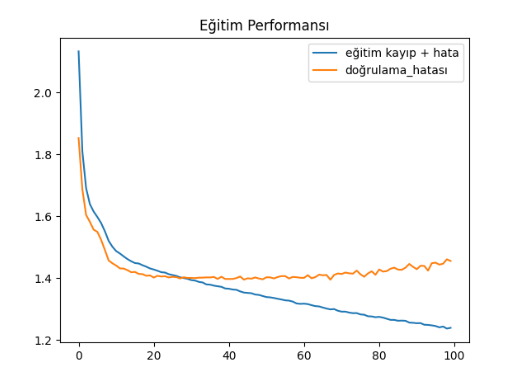